In [23]:
import numpy as np
import tensorflow as tf
import h5py
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import pandas as pd

In [24]:
latent_dim = 128
weights_file = f'./weights/latent_{latent_dim}/weights.ckpt'

In [25]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def reconstruct(self, data):
        z_mean, z_log_var, z = encoder(data)
        reconstruction = decoder(z)
        return reconstruction
    
    def extract_z_values(self, data):
        return encoder(data)[2]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [26]:
# Encoder and Decoder declared with functional API to save all the weights together
encoder_inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(64, kernel_size=4, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(128, kernel_size=4, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(512, kernel_size=4, activation="relu", strides=2, padding="same")(x)
encoded = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(encoded)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(encoded)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 16, 16, 64)   3136        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 8, 8, 128)    131200      conv2d_3[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 4, 4, 512)    1049088     conv2d_4[0][0]                   
____________________________________________________________________________________________

In [27]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(2048)(latent_inputs)
x = layers.Reshape((4, 4, 128))(x)
x = layers.Conv2DTranspose(256, kernel_size=4, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, kernel_size=4, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, kernel_size=4, activation="relu", strides=2, padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              264192    
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 8, 8, 256)         524544    
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 16, 16, 64)        262208    
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 32, 32, 3)         3075      
Total params: 1,054,019
Trainable params: 1,054,019
Non-trainable params: 0
_________________________________________________

In [28]:
test_file = '../data/camelyonpatch_level_2_split_test_x.h5'
test_x = h5py.File(test_file, 'r', libver='latest', swmr=True)['x']

In [29]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.load_weights(weights_file)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


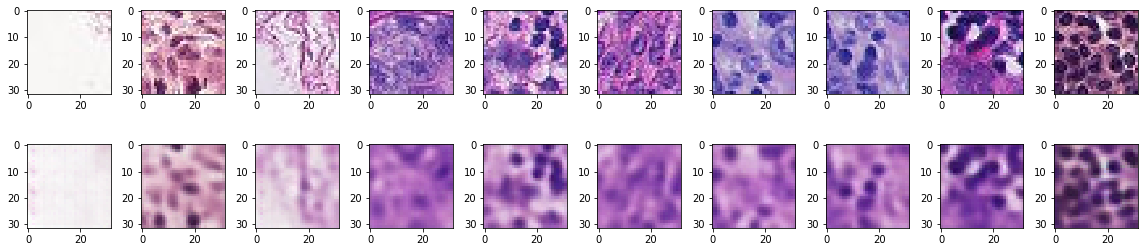

In [8]:
# display results
import matplotlib.pyplot as plt

n_rec = 10

x_batch = test_x[0:n_rec,:32,:32] / 255.

plt.figure(figsize=(n_rec+6,4))

pred_img = vae.reconstruct(x_batch)

for i in range(n_rec):
    
    plt.subplot(2, n_rec, i+1)
    plt.imshow(x_batch[i])

    plt.subplot(2, n_rec, n_rec+i+1)
    plt.imshow(pred_img[i])

plt.tight_layout()

### Latent Space Analysis
Below we are selecting a subset of 5000 images to do pca on the latent space and inspect the PCs with the biggest variance. 
#### Remarks: 
- In an ideal case the KL-Divergence term approaches 0, which means the latent space will have a spherical variance. But with the training with lesser latent dimensions, there's always some unnormalized variances left, which we can use to do pca and get the strongest components
- The first cell with interact just initializes 10 images with z value 0, and then adds noise to one of the latent dimensions, the number of the dimension does not matter here, as it does not resemble any importance. The top left image is the result of negative value added to that dimension in z space, bottom right is positive
- The second cell with interact employs pca to add the noise, which will result in changes in the most deviating components, the number of components matter in this case, as the #0 is the strongest
- Currently not sure that if PCA is supposed to do anything informative here, if there's no linear correlation in the latent space, it might be useless. But we can keep it as a Proof of Concept, and try other approaches in the future

In [31]:
# A subset of 5000 images is selected here
z_vals = vae.extract_z_values(test_x[:5000,32:64,32:64] / 255.).numpy().squeeze()

In [32]:
from ipywidgets import interact

# select the latent dim to explore 
def visualize_latent_dim(dim_number):
    n_rec = 10
    z_values = np.zeros((10,128))
    z_values[:,dim_number] = np.linspace(-3,3,n_rec)
    generated = decoder(z_values)
    plt.figure(figsize=(n_rec+6,4))

    for i in range(n_rec):

        plt.subplot(2, n_rec/2, i+1)
        plt.imshow(generated[i])

interact(visualize_latent_dim, dim_number=(0,15));

interactive(children=(IntSlider(value=7, description='dim_number', max=15), Output()), _dom_classes=('widget-i…

In [11]:
#PCA Here
examples = z_vals.T
examples.shape
cov = np.cov(examples)
E, V  = np.linalg.eig(cov)

In [39]:
# Number of PCs to be visualized
M_Components = 5

#Change the image index to add noise to different images, and inspect
image_index = 100

def visualize_latent_dim(eig_num):
    z_values = np.repeat(z_vals[image_index][:,np.newaxis], 10, axis=1).T
    linear_noise =  np.linspace(-5,5,10)
    z_values += (V[eig_num:eig_num+1] * linear_noise.reshape(10,1))
    generated = decoder(z_values)
    plt.figure(figsize=(n_rec+6,6))

    for i in range(n_rec):

        plt.subplot(2, n_rec/2, i+1)
        plt.imshow(generated[i])
        plt.title(f"{round(linear_noise[i],2)} * PC {eig_num}")

interact(visualize_latent_dim, eig_num=(0,4));

interactive(children=(IntSlider(value=2, description='eig_num', max=4), Output()), _dom_classes=('widget-inter…